In [1]:
import pandas as pd
import numpy as np


# library untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# library untuk analisis timeseries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# library untuk forecasting
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


In [2]:
import pandas as pd # Python library for data analysis and data frame
import numpy as np # Numerical Python library for linear algebra and computations

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8); # setting the figuresize 

from datetime import datetime, date #Library to deal with datetime columns

# time series analysis libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# time series forecasting libraries
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

# Neural network required libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# model evaluation libraries
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

#for saving trained model
import pickle

import warnings
warnings.filterwarnings("ignore") # To prevent kernel from showing any warning

Memanggil Dataset

In [4]:
df = pd.read_excel('CO2 dataset.xlsx')

In [5]:
df.head()

,Year,CO2
0,1800,0.00568
1,1801,0.00561
2,1802,0.00555
3,1803,0.00548
4,1804,0.00542


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    215 non-null    int64  
 1   CO2     215 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.5 KB


Transform Data

In [7]:
df['Year'] = pd.to_datetime(df['Year'], format="%Y")

In [8]:
df.set_index(['Year'], inplace=True)

In [9]:
df.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [10]:
df.index.min(), df.index.max()

(Timestamp('1800-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00'))

In [11]:
if (df.index.max() - df.index.min() == 214):
    print ('Data is continues')

In [12]:
df.index.freq = 'YS'

Analisas Timeseries

<AxesSubplot:xlabel='Year'>

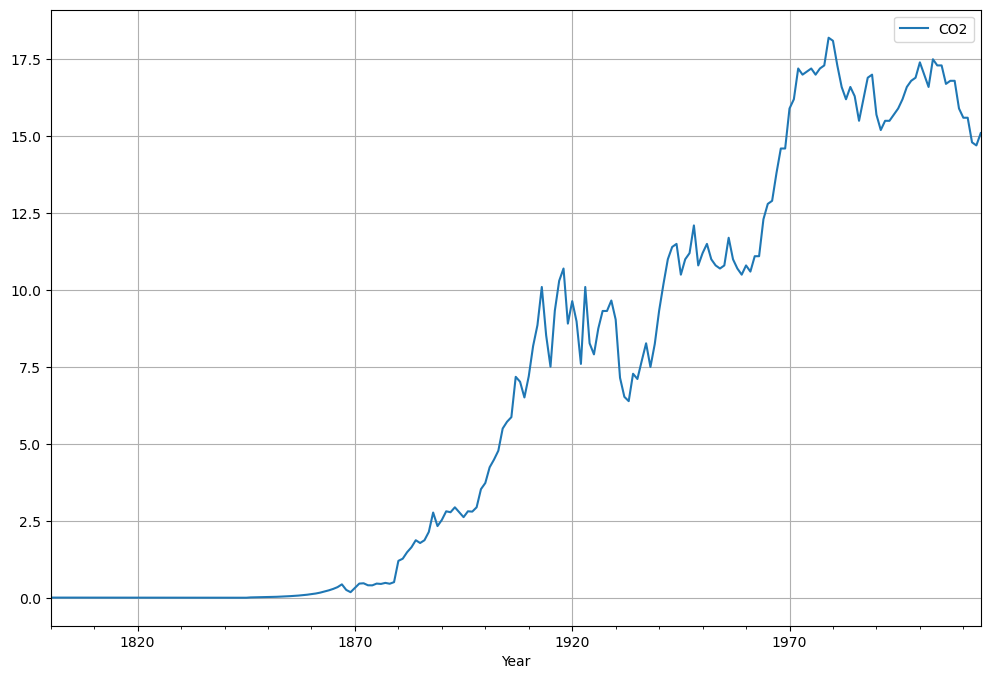

In [13]:
df.plot(grid=True)

In [14]:


# Train test split the dataset
train_df = df.loc[:'1991-01-01']
test_df = df.loc['1992-01-01':]



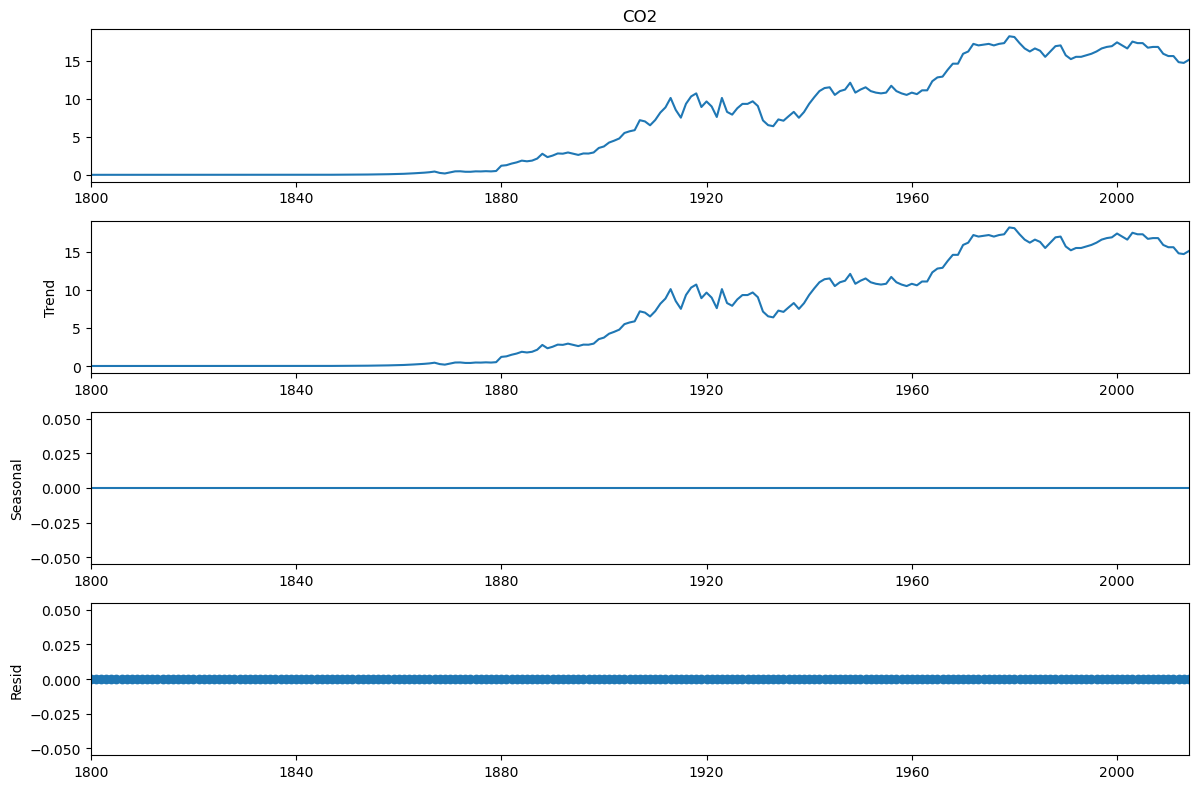

In [15]:
decompose_add = seasonal_decompose(df['CO2'])
decompose_add.plot();

In [16]:
# functon for adf test
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    print ('----------------------------------------------')
    adftest = adfuller(timeseries)
    adf_output = pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in adftest[4].items():
        adf_output['Critical Value (%s)'%key] = value
    print (adf_output)
    
# calling adf function and passing series
adf_test(df.values)

Results of Dickey-Fuller Test:
----------------------------------------------
Test Statistic                  -0.378463
p-value                          0.913633
#Lags Used                       0.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


In [17]:


diff_df = df.diff() #first differencing for stationarity
diff_df.head()



,CO2
Year,
1800-01-01,NaN
1801-01-01,-0.00007
1802-01-01,-0.00006
1803-01-01,-0.00007
1804-01-01,-0.00006


In [18]:


diff_df.dropna(inplace=True) # depending on your differenced order you might have 1,2 or 3 null values, remove those



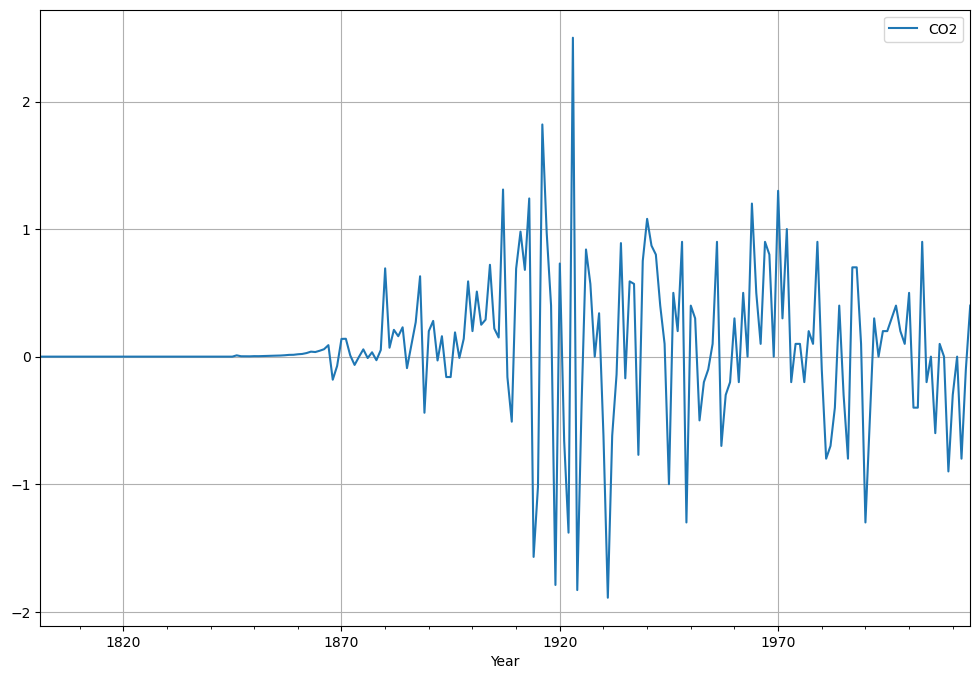

In [19]:


diff_df.plot(grid=True);



In [20]:


# call the adf_test function and pass differenced series
adf_test(diff_df)



Results of Dickey-Fuller Test:
----------------------------------------------
Test Statistic                  -3.780005
p-value                          0.003119
#Lags Used                      15.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64


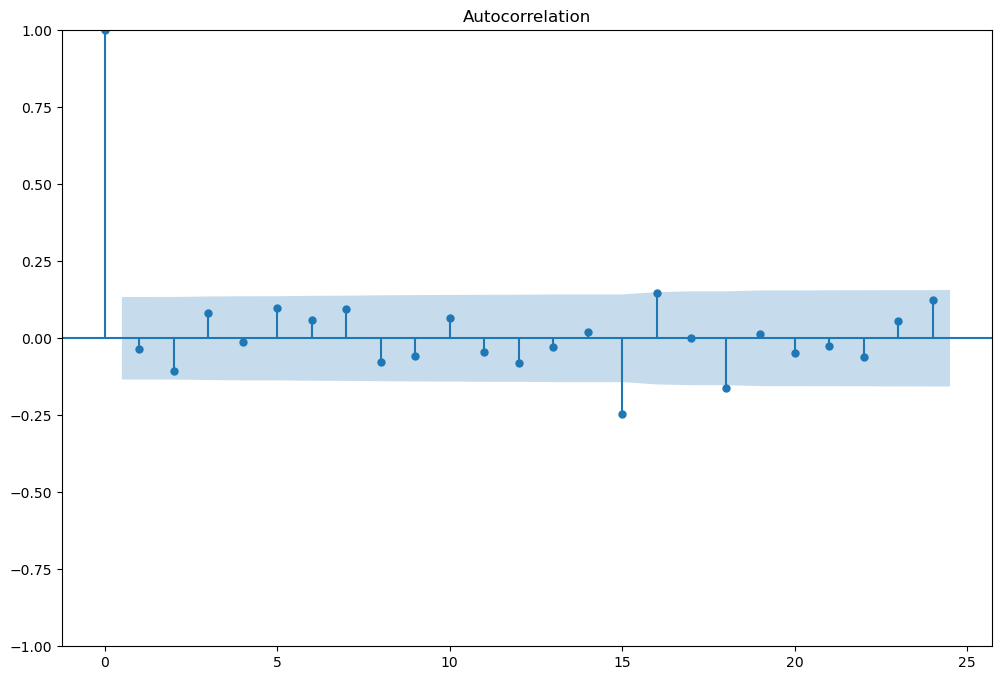

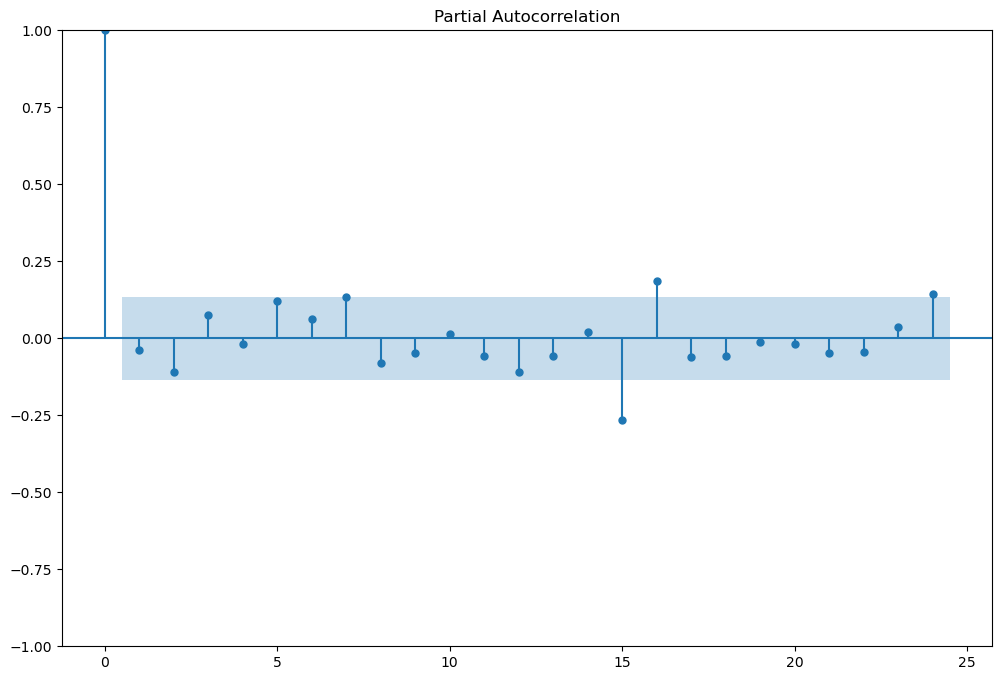

In [21]:


# if the series is not stationary then make sure to pass differenced series instead of original series
plot_acf(diff_df);
plot_pacf(diff_df);



In [22]:
single_exp = SimpleExpSmoothing(train_df).fit()
single_exp_train_pred = single_exp.fittedvalues
single_exp_test_pred = single_exp.forecast(23)

<AxesSubplot:xlabel='Year'>

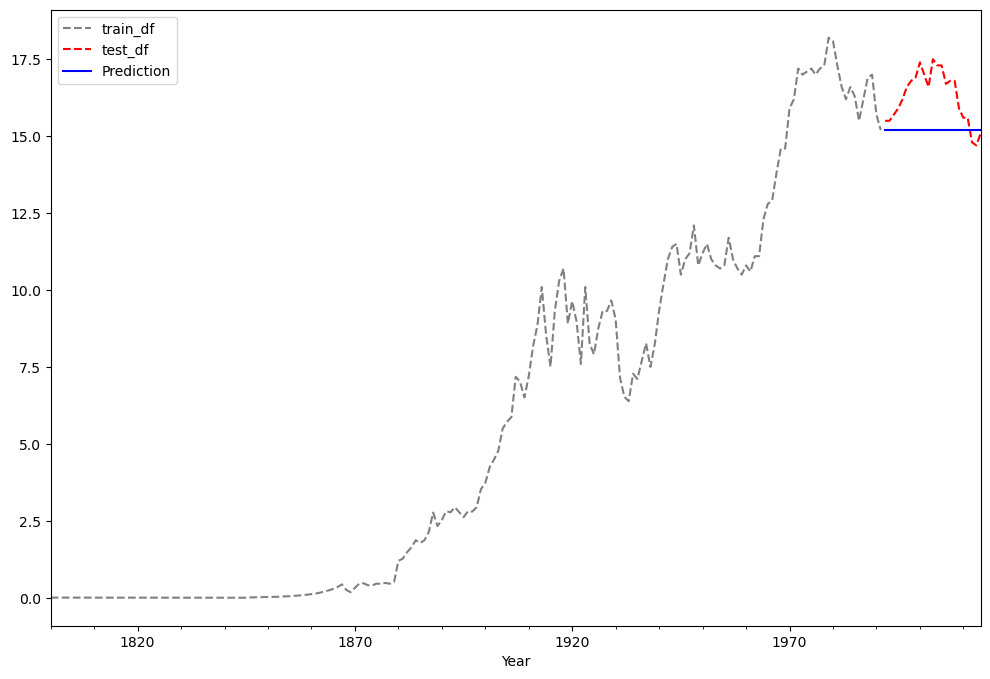

In [23]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
single_exp_test_pred.plot(color='b', legend=True, label='Prediction')

In [24]:
print('Train RMSE:',mean_squared_error(train_df, single_exp_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, single_exp_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, single_exp_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, single_exp_test_pred))

Train RMSE: 0.5646920026800116
Test RMSE: 1.342911302270165
Train MAPE: 0.08470530767414804
Test MAPE: 0.06861466412077383


In [25]:
double_exp = ExponentialSmoothing(train_df, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
double_exp_train_pred = double_exp.fittedvalues
double_exp_test_pred = double_exp.forecast(23)

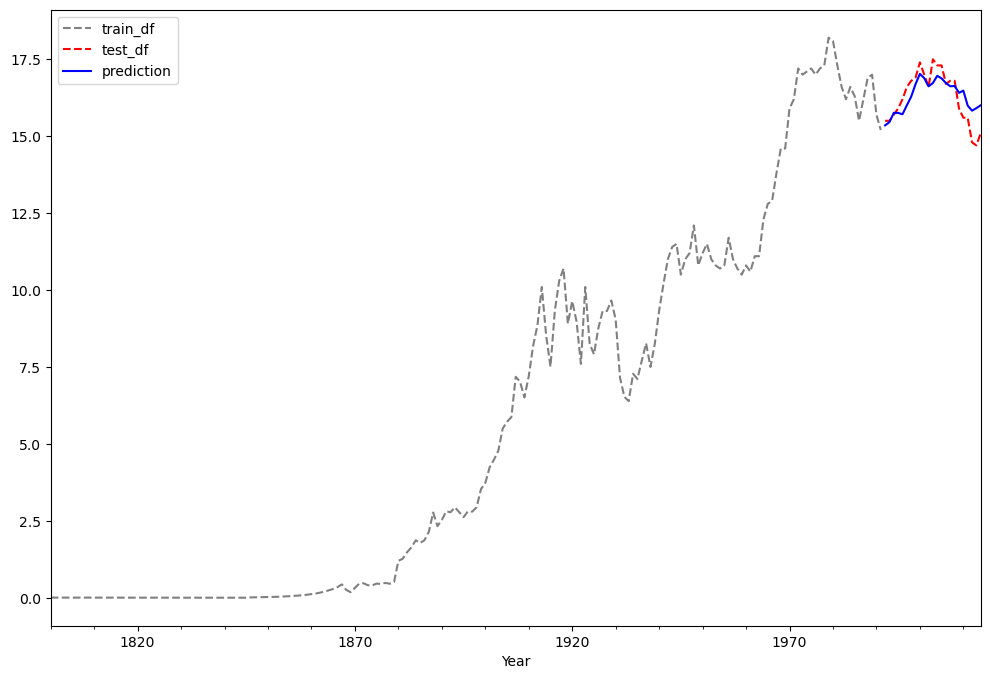

In [26]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
double_exp_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()


In [27]:


print('Train RMSE:',mean_squared_error(train_df, double_exp_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, double_exp_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, double_exp_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, double_exp_test_pred))



Train RMSE: 0.5219963052653047
Test RMSE: 0.5352720574221986
Train MAPE: 12.80676949834386
Test MAPE: 0.026063825837478335


ARIMA

In [28]:
ar = ARIMA(train_df, order=(15,1,15)).fit()
ar_train_pred = ar.fittedvalues
ar_test_pred = ar.forecast(23)

<AxesSubplot:xlabel='Year'>

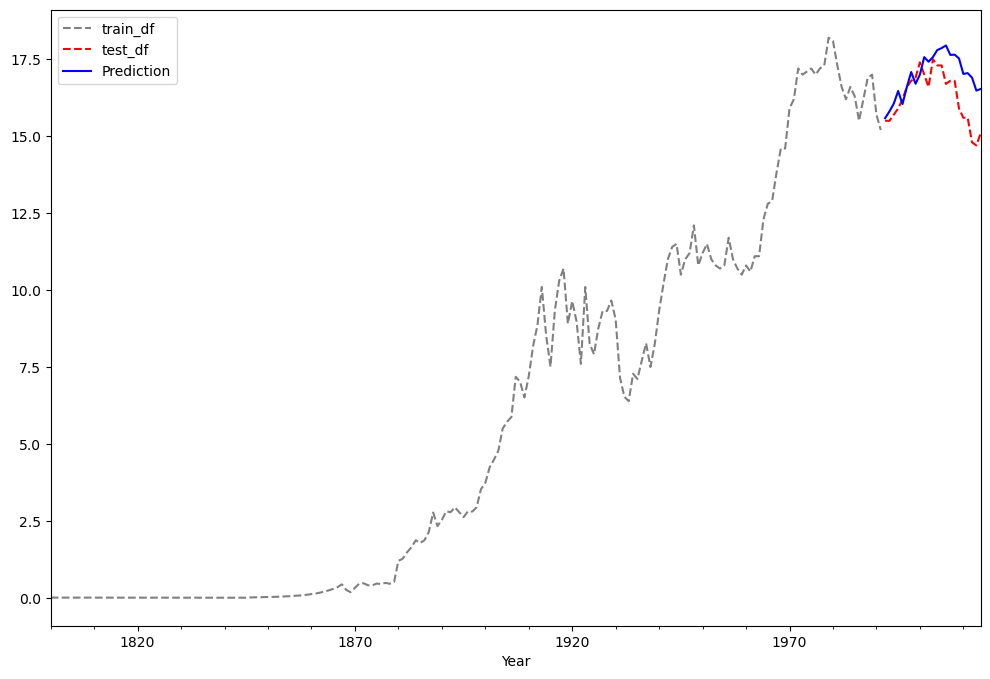

In [29]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
ar_test_pred.plot(color='b', legend=True, label='Prediction')

In [30]:
print('Train RMSE:',mean_squared_error(train_df, ar_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, ar_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, ar_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, ar_test_pred))

Train RMSE: 0.46787864247372035
Test RMSE: 0.9745051010771202
Train MAPE: 0.08138870593514747
Test MAPE: 0.04842924598979627


In [31]:


comparision_df = pd.DataFrame(data=[['Single exp smoothing', 1.3429 , 0.0686],
                           ['double exp smoothing', 0.5352,  0.0260],
                          ['ARIMA(15,1,15)', 0.9591, 0.0475]], columns=['Model','RMSE','MAPE'])

comparision_df.set_index('Model', inplace=True)



In [32]:
comparision_df.sort_values(by='RMSE')

,RMSE,MAPE
Model,,
double exp smoothing,0.5352,0.0260
"ARIMA(15,1,15)",0.9591,0.0475
Single exp smoothing,1.3429,0.0686


In [33]:
import pickle

In [34]:
pickle.dump(double_exp, open('prediksi_co2.sav','wb'))